# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
    
_set_env("OPENAI_API_KEY")

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-qwq-32b")
llm.invoke(messages)

AIMessage(content='\n<think>\nOkay, the user is interested in ocean mammals beyond whales. Let me think of the main categories first. Cetaceans, pinnipeds, sirenians, and maybe some others like otters and manatees.\n\nWait, they already mentioned whales, which are cetaceans. So I should focus on other cetaceans like dolphins and porpoises. Then move on to pinnipeds—seals, sea lions, walruses. Sirenians include manatees and dugongs. \n\nI should also mention the differences between some groups, like how seals differ from sea lions. Maybe include some unique species like the narwhal or the vaquita. \n\nDon\'t forget to mention conservation status for some of these, like the vaquita being critically endangered. That adds context about their importance. \n\nI need to structure it in a way that\'s easy to follow. Start with other cetaceans, then pinnipeds, sirenians, and then maybe a few others like otters. Highlight some interesting facts to make it engaging. \n\nAlso, check if there\'s an

We can run our chat model in a simple graph with `MessagesState`.

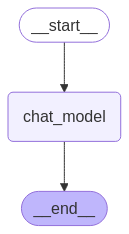

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.graph import MessagesState

def chat_model(state: MessagesState): 
    return {"messages": llm.invoke(state["messages"])}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================


<think>
Okay, the user is interested in ocean mammals beyond whales. Let me think of other species they might not know about.

First, dolphins come to mind, but they're pretty well-known too. Maybe start with the less obvious ones. Like porpoises? They often get confused with dolphins. I should mention the differences between them.

Then there's the manatee and dugong. They're in different regions, so pointing out their habitats could be useful. People might not realize they're in warm coastal areas.

Sea otters are definitely mammals, but sometimes people forget since they're not as big as whales. Their role in

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.